# OD calculation
Notebook calculating the optical density and fitting the marginals (non-normalized) to a gaussian distribution.

This notebook includes some pointers on using `scikit-images` for image processing, which could be helpful.

It is important to note that the axes of images are flipped, ordered `[y][x]`.

In [1]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [3]:
example_dir = wd / "test_data" #test data directory

#each image has an accompanying background image with just noise
im0 = imread(example_dir / "img_0.tif")
im0_background = imread(example_dir / "img_2.tif")

#I am unclear on why the second image is necessary
im1 = imread(example_dir / "img_1.tif")
im1_background = imread(example_dir / "img_3.tif")

/tmp/ipykernel_17199/2697091872.py:10: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


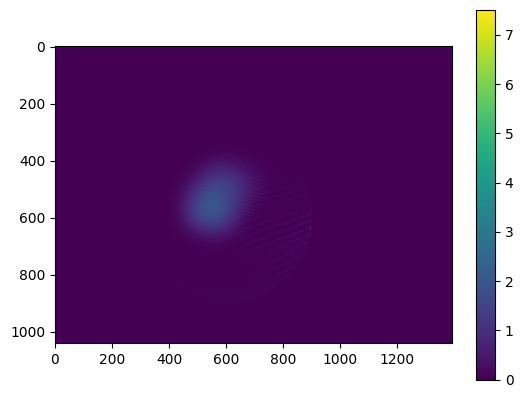

In [4]:
#get background intensity value with noise subtracted
I0_arr=np.subtract(np.array(im0),
                    np.array(im0_background)).astype(int)

#get foreground intensity with noise subtracted
I_arr=np.subtract(np.array(im1),
                    np.array(im1_background)).astype(int)


I_div_arr = np.divide(I_arr, I0_arr)
od_arr = np.log(I_div_arr)

def incircle(center, radius, pt):
    return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

#first pass, just clip anything not within the aperture
for i,row in enumerate(od_arr):
    for j, pixel in enumerate(row):
        if pixel < 0 or not incircle((600,600),300,(i,j)):
            od_arr[i][j] = 0

img1 = plt.imshow(od_arr)
plt.colorbar(img1)

## Create image mask
A couple parameters can be used to mask out the unwanted data. First, `lower_mask` and `upper_mask` are just rough cutoff values. The `value_mask` parameter tries to get as much of the blob as possible while cutting off the noise. This can be set low, because the median mask will eliminate the outliers.

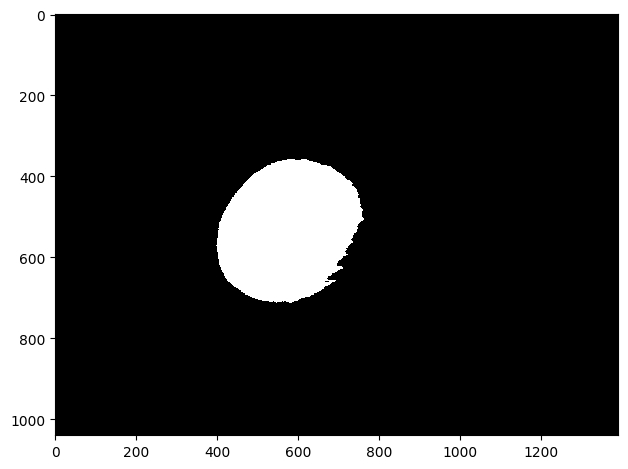

In [5]:
lower_mask = od_arr[:,:] > 0
upper_mask = od_arr[:,:] < 5
value_mask = od_arr[:,:] > .05
mask = lower_mask*upper_mask*value_mask

mask_filtered = median_filter(lower_mask*upper_mask*value_mask, 20)
imshow(mask_filtered)

## Get blob bounding box
THe `label` function is used to separate contiguous regions of the image and returns useful properties regarding their shape, location, and orientation.

In [6]:
blobs = label(mask_filtered)
props = regionprops(blobs) #generate a properties dictionary
bbox = props[0].bbox #get the bounding box
bbox 

(357, 398, 715, 762)

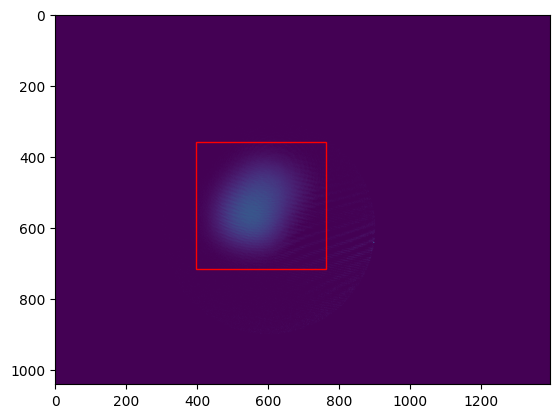

In [7]:
#draw bounding box
fig, ax = plt.subplots()
rect = plt.Rectangle((bbox[1],bbox[0]),bbox[3]-bbox[1], bbox[2]-bbox[0])
rect.set(fill=False, color = "red")
ax.add_artist(rect)
ax.imshow(od_arr)

In [8]:
#extract blob rectangle from image
blob_arr = od_arr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
#apply a median filter
blob_arr = median_filter(blob_arr, 3)

In [9]:
#compute marginals and fit to a gaussian
def gaussian_fit(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

x, y = margins(blob_arr)
x = x.T[0]
y = y[0]

popt_x, pcov_x = curve_fit(gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
popt_y, pcov_y = curve_fit(gaussian_fit, np.arange(len(y)), y, [350,150,60])

<ErrorbarContainer object of 3 artists>

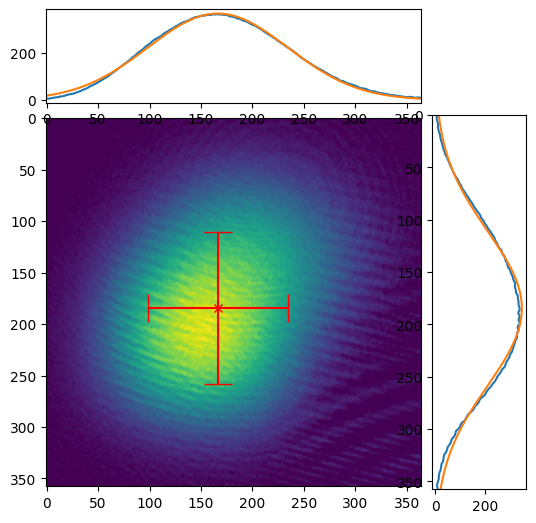

In [10]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax.imshow(blob_arr)

#axes are flipped!!
ax_y = fig.add_subplot(gs[0,0], sharex=ax)
ax_x = fig.add_subplot(gs[1,1], sharey=ax)

ax_y.plot(y)
ax_y.plot(np.arange(len(y)), gaussian_fit(np.arange(len(y)),*popt_y))

ax_x.plot(x, np.arange(len(x)))
ax_x.plot(gaussian_fit(np.arange(len(x)),*popt_x),np.arange(len(x)))

ax.errorbar(popt_y[1], popt_x[1], xerr = popt_y[2], yerr = popt_x[2], color = 'r', marker = "x", capsize = 10)

In [ ]:
print("OD max:", np.max(blob_arr))

OD max: 2.0828603484286212


In [2]:
import datarun

In [27]:
import importlib
importlib.reload(datarun)

<module 'datarun' from '/home/ben/Documents/Repos/MOTsArentForKids/datarun.py'>

In [28]:
d = datarun.DataRun("./test_data/img",1, avg_area = (200,75,300,125))
"""
                   mask = .1, #threshold for mask filter
        blob_dim = 300, #size of blob box to fit
        box = 3, #size of box for image median filter
        mask_box = 50, #size of box for image mask
        circle = [(530, 690), 300], #center/radius of viewport circle
        avg_area = (200, 75, 300, 125) 
                    )"""

'\n                   mask = .1, #threshold for mask filter\n        blob_dim = 300, #size of blob box to fit\n        box = 3, #size of box for image median filter\n        mask_box = 50, #size of box for image mask\n        circle = [(530, 690), 300], #center/radius of viewport circle\n        avg_area = (200, 75, 300, 125) \n                    )'

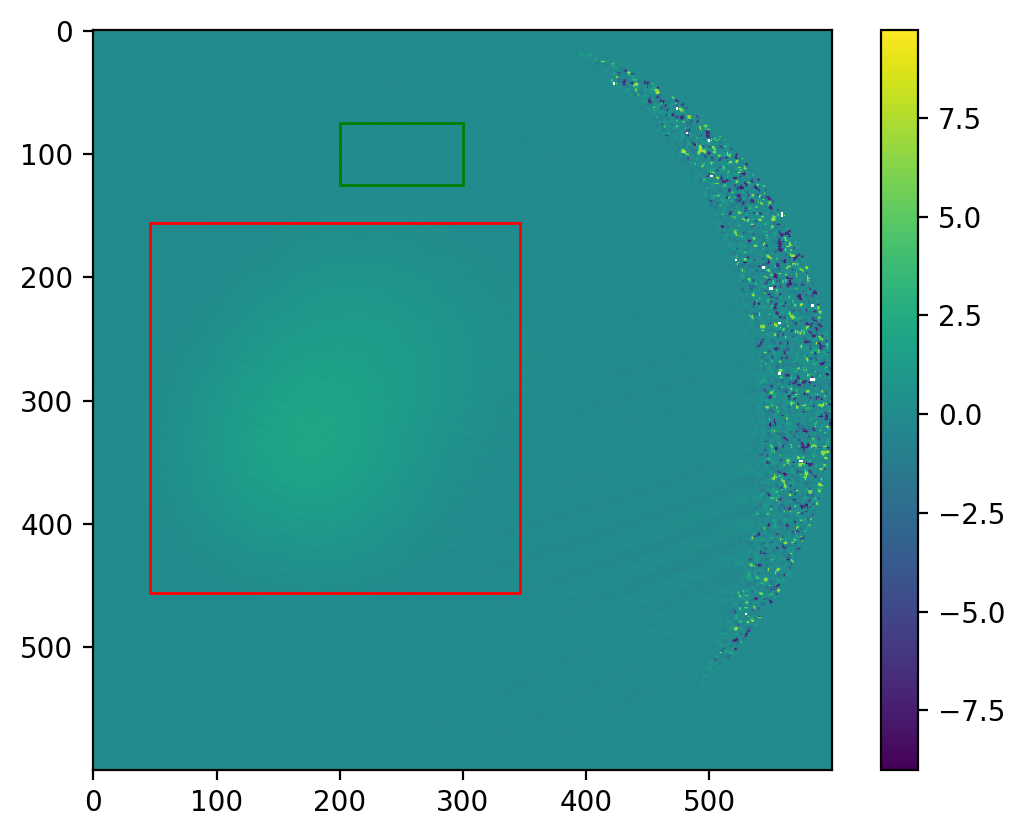

In [26]:
d.plot_blob()

In [24]:
d.atom_number()

126838697.46634163

In [25]:
np.max(d.blob)

2.0937007078609486

In [10]:
plt.imshow(od_arr)

filt = od_arr > .25
filt_mask = median_filter(filt, 50)
reigons = label(filt_mask)
props = regionprops(filt_mask)

In [ ]:
plt.imshow(filt_mask)

In [ ]:
k
def find_blob(self):
    value_mask = self.od_arr > self.mask
    self.mask_filtered = median_filter(value_mask, self.mask_box)

    blobs = label(self.mask_filtered)
    props = regionprops(blobs) #generate a properties dictionary

    if not len(props) == 1:
        raise Exception(f"Found {len(props)} blobs")
    self.cy, self.cx = props[0].centroid
    
    self.blob = self.od_arr[
        round(self.cy-self.blob_dim/2):round(self.cy+self.blob_dim/2), 
        round(self.cx-self.blob_dim/2):round(self.cx+self.blob_dim/2)
    ]

    self.yaxis = np.arange(len(self.blob))*self.DISTANCE_SCALE
    self.xaxis = np.arange(len(self.blob[0]))*self.DISTANCE_SCALE


def gaussian_fit(self, x, A, mu, sigma, B):
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + B

def fit(self):
    #compute marginals and fit to a gaussian
    y, x = margins(self.blob)
    x = x[0]
    y = y.T[0]

    x[x == np.inf] = 0
    y[y == np.inf] = 0

    self.popt_x, self.pcov_x = curve_fit(
        self.gaussian_fit, 
        self.xaxis, 
        x, 
        p0 =[350, 3.2e-4, 1.3e-4, 0]
    )

    self.popt_y, self.pcov_y = curve_fit(
        self.gaussian_fit, 
        self.yaxis,
        y, 
        [350,3.2e-4, 1.3e-4, 0]
    )

    self.x = x
    self.y = y

def atom_number(self):
    x = np.arange(-10*self.popt_x[2], 10*self.popt_x[2], self.DISTANCE_SCALE/20)

    abs_CS = 2.46-15 #number found by comparison with sample data... About two orders
    #of magnitude smaller

    return np.trapz(
        self.gaussian_fit(x, *self.popt_x[:3], 0),
        x
    )*self.DISTANCE_SCALE/2.46e-15

def atom_number_px_sum(self):
    abs_CS=(766.5e-9)**2/(2*np.pi)
    return np.sum(self.blob)-0.5*(self.popt_x[3]+self.popt_y[3])*self.DISTANCE_SCALE**2/abs_CS
    
def plot_blob(self):
    fig, ax = plt.subplots()

    blob_rect = (
        self.cx-self.blob_dim/2,
        self.cy-self.blob_dim/2, 
        self.cx+self.blob_dim/2, 
        self.cy+self.blob_dim/2
    )

    rect1 = Rectangle(
        (blob_rect[0],blob_rect[1]),
        (blob_rect[2]-blob_rect[0]),
        (blob_rect[3]-blob_rect[1]), 
        fill=False,
        color = "r"
    )
    rect2 = Rectangle(
        (self.avg_area[0],self.avg_area[1]),
        (self.avg_area[2]-self.avg_area[0]),
        (self.avg_area[3]-self.avg_area[1]), 
        fill=False,
        color = "g"
    )

    ax.add_artist(rect1)
    ax.add_artist(rect2)
    im = ax.imshow(self.od_arr)
    
    fig.colorbar(im)
    fig.set_dpi(200)

def plot_fit(self):

    fig = plt.figure(
        figsize=(6,6),
        dpi = 200
    )
    gs = fig.add_gridspec(
        2, 2,  
        width_ratios=(4, 1), height_ratios=(1, 4),
        left=0.1, right=0.9, bottom=0.1, top=0.9,
        wspace=0.05, hspace=0.05
    )
    ax = fig.add_subplot(gs[1,0])

    ax.imshow(self.blob, extent = (0, max(self.xaxis), 0, max(self.yaxis)))

    ax_x = fig.add_subplot(gs[0,0], sharex=ax)
    ax_y = fig.add_subplot(gs[1,1], sharey=ax)

    ax_x.plot(self.xaxis, self.x, color="r")
    ax_x.plot(
        self.xaxis,
        self.gaussian_fit(self.xaxis, *self.popt_x),
        color = "b"
    )
    ax_x.set_ylabel("OD (dim.)")
    plt.setp(ax_x.get_xticklabels(), visible = False)

    #flip the axes for y
    ax_y.plot(self.y, self.yaxis, color = "r") 
    ax_y.plot(
        self.gaussian_fit(self.yaxis, *self.popt_y),
        self.yaxis,
        color = "b"
    )
    ax_y.set_xlabel("OD (dim.)")
    plt.setp(ax_y.get_yticklabels(), visible = False)

    ax.errorbar(
        self.popt_x[1], 
        self.popt_y[1], 
        xerr = np.abs(self.popt_x[2]), 
        yerr = np.abs(self.popt_y[2]), 
        color = "r", 
        marker = "x", 
        capsize = 10
    )

    def tick_format(val, num):
        return "{:.2f}".format(val * 1e3)

    ax.xaxis.set_major_formatter(tick_format)
    ax.yaxis.set_major_formatter(tick_format)

    ax.set_xlabel(r"$x \ (mm)$")
    ax.set_ylabel(r"$y \ (mm)$")